# Code modified from Notebook

In [1]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_decision_forests as tfdf

2024-08-23 15:27:40.920445: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_file_path = '../Data/Data/Original Data/train.csv'
test_file_path = '../Data/Data/Original Data/test.csv'
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)
train_df = train_df.drop("Id", axis=1)
df_num = train_df.select_dtypes(include = ['float64', 'int64'])

In [3]:
# function split_dataset splits the dataset into training and validation sets

#creates a boolean array of same length of dataset: True if element in array is smaller than test_ratio
  # All True values are stored in test_indices 
  # Function outputs train ds and test ds
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(train_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1182 examples in training, 278 examples in testing.


### Covert the dataset from Pandas format to TensorFlow format

# Pandas:
### -Used for data manipulation and analysis in Python/cleaning/exploratory
### -Structure: Tabular data structure with labeled axes

# TensorFlow: 
### -Designed for building efficient input pipelines for machine learning models in TensorFlow
### -Structure: Sequence of elements, where each element is a tuple of tensors

In [4]:
# Target column we want to predict
label = 'SalePrice'

# Convert the pandas dataframes to tensorflow datasets
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

In [5]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.16.2
TensorFlow Decision Forests v1.9.0


In [6]:
# TensorFlow Random Forest Model is called rf
# tfdf.keras.RandomForestModel is a class from the TensorFlow Decision Forests library
# hyperparameter_template="benchmark_rank1" specifies a predefined set of hyperparameters for the RandomForestModel
# task = tfdf.keras.Task.REGRESSION specifies that we are performing regression (as oppoesed to classification)
rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)

# rf.compile : method that configues the model for training
# metrics=["mse"] : mean squared error is used as the evaluation metric
rf.compile(metrics=["mse"])



Use /var/folders/r0/qp6_p2111v1dzb0fg2bbfqsr0000gn/T/tmpxxu2gmre as temporary training directory


In [7]:
# Train the Model
rf.fit(train_ds)

Reading training dataset...
Training dataset read in 0:00:06.018293. Found 1182 examples.
Training model...


[INFO 24-08-23 15:27:52.2463 BST kernel.cc:1233] Loading model from path /var/folders/r0/qp6_p2111v1dzb0fg2bbfqsr0000gn/T/tmpxxu2gmre/model/ with prefix 06985ac7050546f8


Model trained in 0:00:01.804582
Compiling model...


[INFO 24-08-23 15:27:52.8097 BST decision_forest.cc:734] Model loaded with 300 root(s), 112332 node(s), and 73 input feature(s).
[INFO 24-08-23 15:27:52.8097 BST abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-23 15:27:52.8098 BST kernel.cc:1061] Use fast generic engine


Model compiled.


In [8]:
# %matplotlib inline
# from IPython.core.display import display, HTML
# # Visualize the Model
# html_content = tfdf.model_plotter.plot_model(rf, tree_idx=0, max_depth=3)
# display(HTML(html_content))

In [9]:
print(rf.summary())

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (79):
	1stFlrSF
	2ndFlrSF
	3SsnPorch
	Alley
	BedroomAbvGr
	BldgType
	BsmtCond
	BsmtExposure
	BsmtFinSF1
	BsmtFinSF2
	BsmtFinType1
	BsmtFinType2
	BsmtFullBath
	BsmtHalfBath
	BsmtQual
	BsmtUnfSF
	CentralAir
	Condition1
	Condition2
	Electrical
	EnclosedPorch
	ExterCond
	ExterQual
	Exterior1st
	Exterior2nd
	Fence
	FireplaceQu
	Fireplaces
	Foundation
	FullBath
	Functional
	GarageArea
	GarageCars
	GarageCond
	GarageFinish
	GarageQual
	GarageType
	GarageYrBlt
	GrLivArea
	HalfBath
	Heating
	HeatingQC
	HouseStyle
	KitchenAbvGr
	KitchenQual
	LandContour
	LandSlope
	LotArea
	LotConfig
	LotFrontage
	LotShape
	

### Evaluate the model on the Out Of Bag (OOB) data and the validation dataset

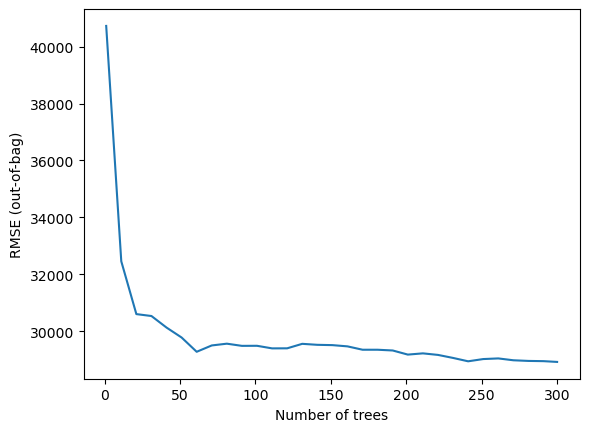

In [10]:
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [11]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1182, accuracy=None, loss=None, rmse=28923.466217299483, ndcg=None, aucs=None, auuc=None, qini=None)

In [12]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 6s 6s/step - loss: 0.0000e+00 - mse: 800318080.0000
loss: 0.0000
mse: 800318080.0000


# Variable Importances

### Indicate how much a feature contributes to the model predictions or quality. 
### Code below is using the TensorFlow Decision Tree variable importances method.

In [13]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 SUM_SCORE
	 NUM_AS_ROOT
	 INV_MEAN_MIN_DEPTH
	 NUM_NODES


In [14]:
# Display the importance features for the variable importance NUM_AS_ROOT
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 108.0),
 ("ExterQual" (4; #22), 63.0),
 ("Neighborhood" (4; #59), 46.0),
 ("GarageCars" (1; #32), 28.0),
 ("TotalBsmtSF" (1; #73), 14.0),
 ("GrLivArea" (1; #38), 13.0),
 ("YearBuilt" (1; #76), 9.0),
 ("KitchenQual" (4; #44), 6.0),
 ("1stFlrSF" (1; #0), 5.0),
 ("GarageArea" (1; #31), 5.0),
 ("BsmtQual" (4; #14), 3.0)]

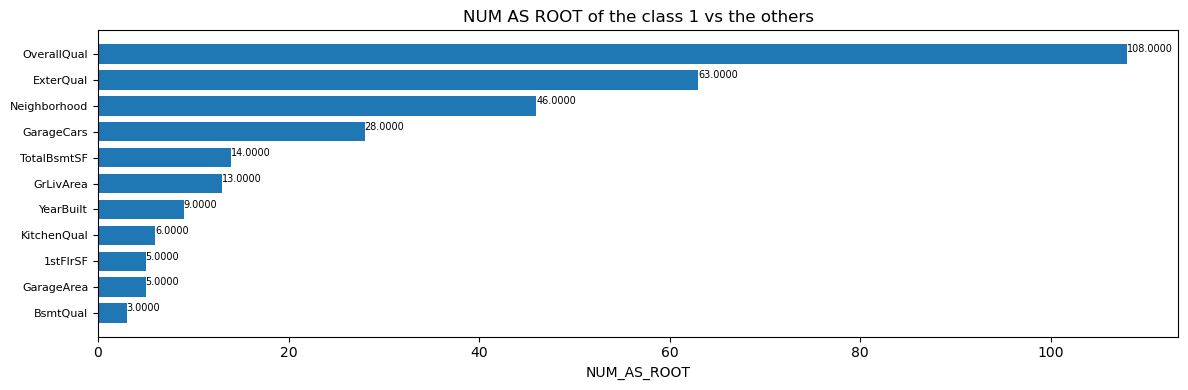

In [15]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, height=0.75, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names, fontsize=8)
plt.gca().invert_yaxis()

# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top", fontsize=7)

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

# Submission

In [16]:
#have already imported the test dataset as test_df
ids = test_df.pop("Id")

# test_df.columns

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids, 'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 1s 26ms/step


,Id,SalePrice
0,1461,127911.750000
1,1462,151529.812500
2,1463,179298.796875
3,1464,183178.421875
4,1465,192186.468750


### Save submission pd.read_csv
### Add SalePrice columns as rf.predict(test_ds)
### Turn df to a csv, index=False
### Check head()


In [17]:
# sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
# sample_submission_df['SalePrice'] = rf.predict(test_ds)
# sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
# sample_submission_df.head()